In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
import argparse

In [12]:
# Read the Parquet file into a DataFrame
df = pd.read_parquet('../uncon_trained_models/crystal500k_25M_2048/crystal_5.eval')
ar = np.stack(df.iloc[:]['descriptors.xrd_sample.iq'])

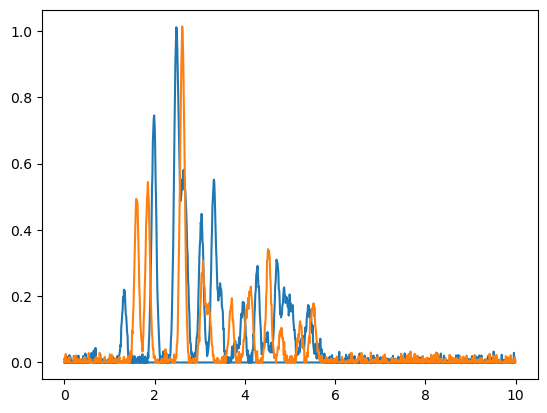

In [3]:
plt.plot(df.iloc[2]['descriptors.xrd_sample.q'], df.iloc[2]['descriptors.xrd_sample.iq'])
plt.plot(df.iloc[2]['descriptors.xrd_gen.q'], df.iloc[2]['descriptors.xrd_gen.iq'])
plt.show()